##**Parte 1**
(25 puntos)

Utilizando el siguiente Dataset:
https://raw.githubusercontent.com/prashant-kikani/breast-cancer-detection/master/breast-cancer-data.csv

Tomar las 30 primeras muestras del dataset de diabetes y utilizar como variables de entrada

* radius_mean
* texture_mean
* perimeter_mean

Variable a predecir: diagnosis

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import math

En primer lugar se cargaron los datos desde la URL, luego se tomaron las 30 primeras muestras, luego se seleccionaron las variables de entrada, que son **radius_mean**, **texture_mean** y **perimeter_mean** en **X**, tenemos la variable a predecir, la cual es **diagnosis**, y finalmente imprimimos las variables de entrada y la variable a predecir.

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/prashant-kikani/breast-cancer-detection/master/breast-cancer-data.csv")

primeras_muestras = data.head(30)

variables_entrada = primeras_muestras[['radius_mean', 'texture_mean', 'perimeter_mean']]

variable_prediccion = primeras_muestras['diagnosis']

print("Variables de entrada:")
print(variables_entrada)
print("\nVariable a predecir (diagnosis):")
print(variable_prediccion)


Variables de entrada:
    radius_mean  texture_mean  perimeter_mean
0        17.990         10.38          122.80
1        20.570         17.77          132.90
2        19.690         21.25          130.00
3        11.420         20.38           77.58
4        20.290         14.34          135.10
5        12.450         15.70           82.57
6        18.250         19.98          119.60
7        13.710         20.83           90.20
8        13.000         21.82           87.50
9        12.460         24.04           83.97
10       16.020         23.24          102.70
11       15.780         17.89          103.60
12       19.170         24.80          132.40
13       15.850         23.95          103.70
14       13.730         22.61           93.60
15       14.540         27.54           96.73
16       14.680         20.13           94.74
17       16.130         20.68          108.10
18       19.810         22.15          130.00
19       13.540         14.36           87.46
20       13.

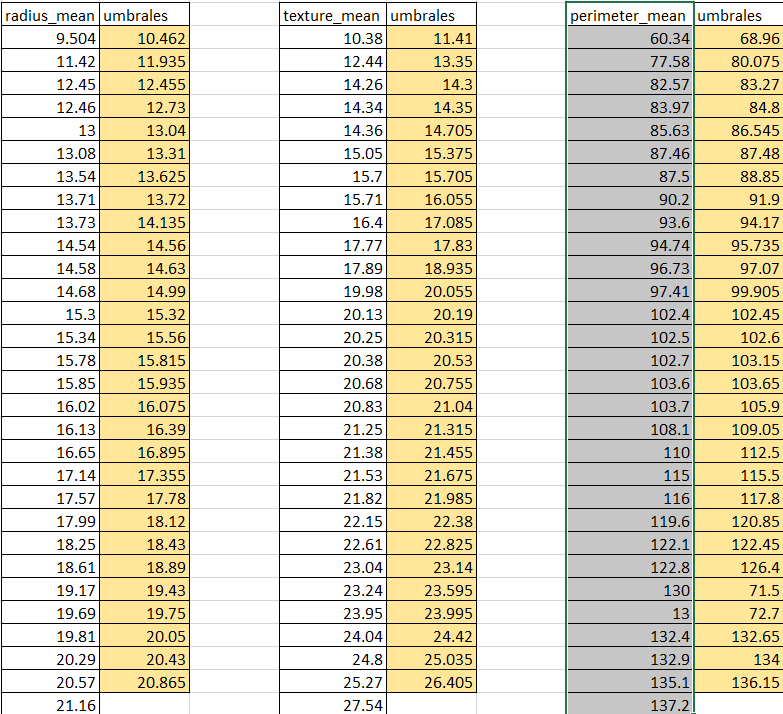

In [ ]:
def entropia(proba1, proba2):
    if proba1 == 0 or proba2 == 0:
        return 0
    return -((proba1) * math.log2(proba1) + (proba2) * math.log2(proba2))

Función para encontrar la mejor división basada en la entropía.
Se cálculo la entropía inicial

In [ ]:
def encontrar_mejor_division(X, y):
    m, n = X.shape
    if m <= 1:
        return None, None, None

    entropia_padre = entropia(np.sum(y == 'M') / m, np.sum(y == 'B') / m)

    mejor_entropia = float('inf')
    mejor_caracteristica = None
    mejor_umbral = None

    for caracteristica in range(n):
        umbrales = np.unique(X[:, caracteristica])
        for umbral in umbrales:
            izquierda = X[:, caracteristica] <= umbral
            derecha = ~izquierda

            if np.sum(izquierda) > 0 and np.sum(derecha) > 0:
                entropia_izquierda = entropia(np.sum(y[izquierda] == 'M') / np.sum(izquierda), np.sum(y[izquierda] == 'B') / np.sum(izquierda))
                entropia_derecha = entropia(np.sum(y[derecha] == 'M') / np.sum(derecha), np.sum(y[derecha] == 'B') / np.sum(derecha))
                entropia_ponderada = (np.sum(izquierda) / m) * entropia_izquierda + (np.sum(derecha) / m) * entropia_derecha

                if entropia_ponderada < mejor_entropia:
                    mejor_entropia = entropia_ponderada
                    mejor_caracteristica = caracteristica
                    mejor_umbral = umbral

    return mejor_caracteristica, mejor_umbral

Función para entrenar un árbol de decisión utilixando entropía personalizada, en el primer condicional tenemos los criterios de parada, profundidad máxima o pureza, en el segundo condicional tenemos que si no se puede encontrar una división que reduzca la entropía, se devuelve la clase predicha.

In [ ]:
def arbol_de_decision_simple(X, y, profundidad=0, profundidad_maxima=3):
    clases_unicas, conteo_clases = np.unique(y, return_counts=True)
    clase_predicha = clases_unicas[np.argmax(conteo_clases)]

    if profundidad == profundidad_maxima or len(clases_unicas) == 1:
        return clase_predicha

    mejor_caracteristica, mejor_umbral = encontrar_mejor_division(X, y)

    if mejor_caracteristica is None:
        return clase_predicha

    izquierda = X[:, mejor_caracteristica] <= mejor_umbral
    derecha = ~izquierda

    subarbol_izquierdo = arbol_de_decision_simple(X[izquierda], y[izquierda], profundidad + 1, profundidad_maxima)
    subarbol_derecho = arbol_de_decision_simple(X[derecha], y[derecha], profundidad + 1, profundidad_maxima)

    entropia_nodo = entropia(np.sum(y == 'M') / len(y), np.sum(y == 'B') / len(y))

    print(f"Profundidad={profundidad}, Característica={mejor_caracteristica}, Umbral={mejor_umbral}, Entropía={entropia_nodo:.4f}")

    return (mejor_caracteristica, mejor_umbral), subarbol_izquierdo, subarbol_derecho

In [ ]:
def calcular_precision(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [ ]:
def imprimir_arbol(arbol, espaciado=""):
    if isinstance(arbol, tuple):
        caracteristica, umbral = arbol[0]
        print(espaciado + f"Característica {caracteristica}, Umbral {umbral}")
        imprimir_arbol(arbol[1], espaciado + "  Izquierda: ")
        imprimir_arbol(arbol[2], espaciado + "  Derecha: ")
    else:
        print(espaciado + f"Clase: {arbol}")

In [ ]:
def validacion_cruzada(X, y, cv=3):
    m = len(y)
    fold_size = m // cv
    accuracies_train = []
    accuracies_valid = []

    for i in range(cv):
        validation_indices = list(range(i * fold_size, (i + 1) * fold_size))
        training_indices = list(set(range(m)) - set(validation_indices))

        X_train, y_train = X[training_indices], y[training_indices]
        X_valid, y_valid = X[validation_indices], y[validation_indices]

        arbol_entrenado = arbol_de_decision_simple(X_train, y_train)

        # Predicciones en el conjunto de entrenamiento
        y_pred_train = np.array([predecir(arbol_entrenado, x) for x in X_train])
        accuracy_train = calcular_precision(y_train, y_pred_train)
        accuracies_train.append(accuracy_train)

        # Predicciones en el conjunto de validación
        y_pred_valid = np.array([predecir(arbol_entrenado, x) for x in X_valid])
        accuracy_valid = calcular_precision(y_valid, y_pred_valid)
        accuracies_valid.append(accuracy_valid)

        print(f"CV {i + 1}: Precisión en entrenamiento = {accuracy_train:.4f}, Precisión en validación = {accuracy_valid:.4f}")

    promedio_accuracy_train = np.mean(accuracies_train)
    promedio_accuracy_valid = np.mean(accuracies_valid)

    return promedio_accuracy_train, promedio_accuracy_valid

In [ ]:
def predecir(arbol, x):
    if isinstance(arbol, tuple):
        caracteristica, umbral = arbol[0]
        if x[caracteristica] <= umbral:
            return predecir(arbol[1], x)
        else:
            return predecir(arbol[2], x)
    else:
        return arbol

Vaiables de entrada, donde la variable a predecir es **diagnosis**

In [ ]:
X = np.array([[17.990, 10.38, 122.80],
              [20.570, 17.77, 132.90],
              [19.690, 21.25, 130.00],
              [11.420, 20.38, 77.58],
              [20.290, 14.34, 135.10],
              [12.450, 15.70, 82.57],
              [18.250, 19.98, 119.60],
              [13.710, 20.83, 90.20],
              [13.000, 21.82, 87.50],
              [12.460, 24.04, 83.97],
              [16.020, 23.24, 102.70],
              [15.780, 17.89, 103.60],
              [19.170, 24.80, 132.40],
              [15.850, 23.95, 103.70],
              [13.730, 22.61, 93.60],
              [14.540, 27.54, 96.73],
              [14.680, 20.13, 94.74],
              [16.130, 20.68, 108.10],
              [19.810, 22.15, 130.00],
              [13.540, 14.36, 87.46],
              [13.080, 15.71, 85.63],
              [9.504, 12.44, 60.34],
              [15.340, 14.26, 102.50],
              [21.160, 23.04, 137.20],
              [16.650, 21.38, 110.00],
              [17.140, 16.40, 116.00],
              [14.580, 21.53, 97.41],
              [18.610, 20.25, 122.10],
              [15.300, 25.27, 102.40],
              [17.570, 15.05, 115.00]])

y = np.array(['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'])

Se entrena el árbol de decisión

In [ ]:
arbol_entrenado = arbol_de_decision_simple(X, y)
print("Árbol de decisión entrenado:")
print(arbol_entrenado)

Profundidad=2, Característica=0, Umbral=9.504, Entropía=0.8113
Profundidad=1, Característica=0, Umbral=12.46, Entropía=1.0000
Profundidad=0, Característica=2, Umbral=87.46, Entropía=0.4690
Árbol de decisión entrenado:
((2, 87.46), ((0, 12.46), ((0, 9.504), 'B', 'M'), 'B'), 'M')


In [ ]:
accuracy_train, accuracy_valid = validacion_cruzada(X, y, cv=3)

print(f"Promedio de precisión en entrenamiento (cv=3): {accuracy_train:.4f}")
print(f"Promedio de precisión en validación (cv=3): {accuracy_valid:.4f}")

Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
CV 1: Precisión en entrenamiento = 1.0000, Precisión en validación = 0.6000
Profundidad=2, Característica=0, Umbral=9.504, Entropía=0.9183
Profundidad=1, Característica=1, Umbral=15.71, Entropía=0.9710
Profundidad=0, Característica=2, Umbral=85.63, Entropía=0.4690
CV 2: Precisión en entrenamiento = 0.9500, Precisión en validación = 0.9000
Profundidad=1, Característica=0, Umbral=13.54, Entropía=0.9183
Profundidad=0, Característica=1, Umbral=14.36, Entropía=0.2864
CV 3: Precisión en entrenamiento = 1.0000, Precisión en validación = 0.9000
Promedio de precisión en entrenamiento (cv=3): 0.9833
Promedio de precisión en validación (cv=3): 0.8000


In [ ]:
imprimir_arbol(arbol_entrenado)

Característica 2, Umbral 87.46
  Izquierda: Característica 0, Umbral 12.46
  Izquierda:   Izquierda: Característica 0, Umbral 9.504
  Izquierda:   Izquierda:   Izquierda: Clase: B
  Izquierda:   Izquierda:   Derecha: Clase: M
  Izquierda:   Derecha: Clase: B
  Derecha: Clase: M


Se dividen los datos en tres partes iguales

In [ ]:
k = 3
fold_size = len(X) // k

Lista para almacenar las precisiones en cada iteración

In [ ]:
accuracies_train = []
accuracies_valid = []

En primer lugar se dividieron los datos en conjuntos de entrenamiento y validación, se realizo la predición en el conjunto de entrenamiento y se cálculo la misma; así mismo se hizo con la parte de validación

In [ ]:
for i in range(k):

    validation_indices = list(range(i * fold_size, (i + 1) * fold_size))
    training_indices = list(set(range(len(X))) - set(validation_indices))

    X_train, y_train = X[training_indices], y[training_indices]
    X_valid, y_valid = X[validation_indices], y[validation_indices]

    tree = arbol_de_decision_simple(X_train, y_train)
    y_pred_train = np.array([arbol_de_decision_simple(X_train, y_train) for _ in range(len(X_train))])
    accuracy_train = np.mean(y_pred_train == y_train)
    accuracies_train.append(accuracy_train)

    y_pred_valid = np.array([arbol_de_decision_simple(X_valid, y_valid) for _ in range(len(X_valid))])
    accuracy_valid = np.mean(y_pred_valid == y_valid)
    accuracies_valid.append(accuracy_valid)

Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía=0.6098
Profundidad=0, Característica=0, Umbral=13.54, Entropía

<ipython-input-247-901c1e91450f>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred_train = np.array([arbol_de_decision_simple(X_train, y_train) for _ in range(len(X_train))])
<ipython-input-247-901c1e91450f>:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  accuracy_train = np.mean(y_pred_train == y_train)


Profundidad=2, Característica=0, Umbral=9.504, Entropía=0.9183
Profundidad=1, Característica=1, Umbral=15.71, Entropía=0.9710
Profundidad=0, Característica=2, Umbral=85.63, Entropía=0.4690
Profundidad=2, Característica=0, Umbral=9.504, Entropía=0.9183
Profundidad=1, Característica=1, Umbral=15.71, Entropía=0.9710
Profundidad=0, Característica=2, Umbral=85.63, Entropía=0.4690
Profundidad=2, Característica=0, Umbral=9.504, Entropía=0.9183
Profundidad=1, Característica=1, Umbral=15.71, Entropía=0.9710
Profundidad=0, Característica=2, Umbral=85.63, Entropía=0.4690
Profundidad=2, Característica=0, Umbral=9.504, Entropía=0.9183
Profundidad=1, Característica=1, Umbral=15.71, Entropía=0.9710
Profundidad=0, Característica=2, Umbral=85.63, Entropía=0.4690
Profundidad=2, Característica=0, Umbral=9.504, Entropía=0.9183
Profundidad=1, Característica=1, Umbral=15.71, Entropía=0.9710
Profundidad=0, Característica=2, Umbral=85.63, Entropía=0.4690
Profundidad=2, Característica=0, Umbral=9.504, Entropía

<ipython-input-247-901c1e91450f>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred_valid = np.array([arbol_de_decision_simple(X_valid, y_valid) for _ in range(len(X_valid))])
<ipython-input-247-901c1e91450f>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  accuracy_valid = np.mean(y_pred_valid == y_valid)


In [ ]:
average_accuracy_train = np.mean(accuracies_train)
average_accuracy_valid = np.mean(accuracies_valid)
print(f"Promedio de precisión en entrenamiento (k={k}): {average_accuracy_train:.2f}")
print(f"Promedio de precisión en validación (k={k}): {average_accuracy_valid:.2f}")

Promedio de precisión en entrenamiento (k=3): 0.00
Promedio de precisión en validación (k=3): 0.33


___

### Probando con sklearn

In [ ]:
model = DecisionTreeClassifier(max_depth=3)

In [ ]:
model.fit(X,y)

DecisionTreeClassifier(max_depth=3)

[Text(0.6666666666666666, 0.875, 'x[2] <= 87.48\ngini = 0.18\nsamples = 30\nvalue = [3, 27]'),
 Text(0.5, 0.625, 'x[0] <= 12.77\ngini = 0.5\nsamples = 6\nvalue = [3, 3]'),
 Text(0.3333333333333333, 0.375, 'x[1] <= 14.07\ngini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(0.16666666666666666, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.8333333333333334, 0.625, 'gini = 0.0\nsamples = 24\nvalue = [0, 24]')]

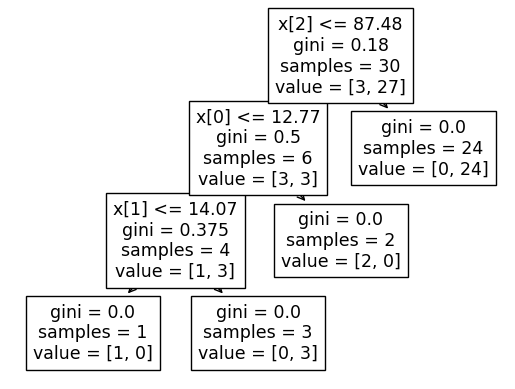

In [ ]:
plot_tree(model)

In [ ]:
scores = cross_val_score(model, X, y, cv=3)
precision_scikit_learn = np.mean(scores)

In [ ]:
scores

array([0.8, 1. , 0.7])

In [ ]:
precision_scikit_learn

0.8333333333333334

En primer lugar se cargará el dataset, se tomaron las 30 muestras, despés se definieron las variables de entrada (features), y la variable a predecir (target). Se dividieron los datos en conjuntos de entrenamiento y prueba.
Se escalaron las caracteristicas para nomalizarlas, así mismo se contruyo el modelo de regresión logística, se entreno el modelo, y por último se cálculo la precisión del modelo.

In [ ]:
url = "https://raw.githubusercontent.com/prashant-kikani/breast-cancer-detection/master/breast-cancer-data.csv"
data = pd.read_csv(url)

features = ['radius_mean', 'texture_mean', 'perimeter_mean']
target = 'diagnosis'

X = data[features].head(30)
y = data[target].head(30)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)


Precisión del modelo: 1.0


##**a) Realizar validación cruzada de cv=3 para un árbol de decisión clasificador de max_depth=3:**

- En cada CV  encontrar un árbol de decisión de max_depth=3 utilizando entropía. Mostrar cada árbol resultante, evaluar Accuracy en train y Accuracy en validación.
En cada proceso de entrenamiento se debe mostrar la entropía para todos los posibles condicionales y cuál se escogió.(12 puntos)


Se seleccionaron las columnas relevantes, se creo el clasificador de árbol de decisión, se realizó la validación cruzada, se muestró el árbol resultante y por último se evaluó el modelo en los datos de entrenamiento y validación

Árbol de decisión en la iteración 1:
Accuracy en train: 1.0000
Accuracy en validación: 0.6000

Árbol de decisión en la iteración 2:
Accuracy en train: 1.0000
Accuracy en validación: 0.9000

Árbol de decisión en la iteración 3:
Accuracy en train: 1.0000
Accuracy en validación: 0.7000



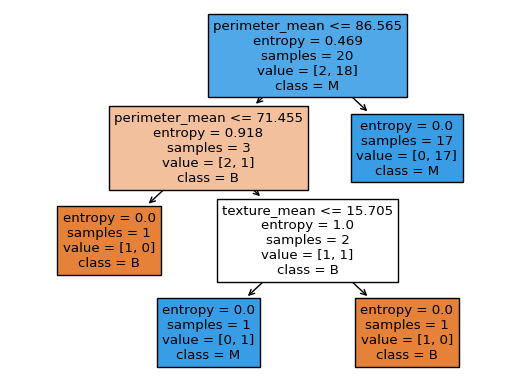

In [ ]:
clf = DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=42)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    clf.fit(X_train, y_train)

    print(f"Árbol de decisión en la iteración {i+1}:")
    plot_tree(clf, feature_names=features, class_names=clf.classes_, filled=True)

    train_acc = clf.score(X_train, y_train)
    val_acc = clf.score(X_val, y_val)

    print(f"Accuracy en train: {train_acc:.4f}")
    print(f"Accuracy en validación: {val_acc:.4f}\n")


[Text(0.6, 0.875, 'x[2] <= 86.565\nentropy = 0.469\nsamples = 20\nvalue = [2, 18]'),
 Text(0.4, 0.625, 'x[2] <= 71.455\nentropy = 0.918\nsamples = 3\nvalue = [2, 1]'),
 Text(0.2, 0.375, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6, 0.375, 'x[1] <= 15.705\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(0.4, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.8, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8, 0.625, 'entropy = 0.0\nsamples = 17\nvalue = [0, 17]')]

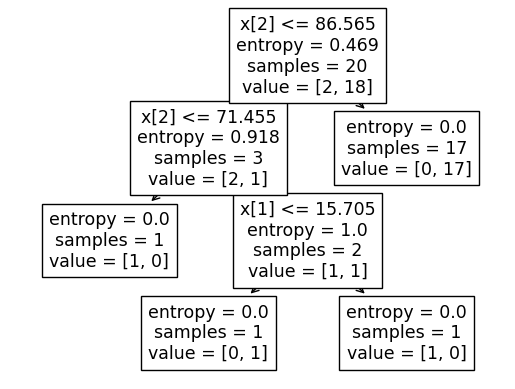

In [ ]:
plot_tree(clf)

##**b) Corroborar los resultados usando Sklearn (2 puntos)**

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=42)

for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    train_accuracy = (y_train_pred == y_train).mean()
    val_accuracy = (y_val_pred == y_val).mean()

    print(f"Iteración {i+1}:")
    print(f"Accuracy en entrenamiento: {train_accuracy:.4f}")
    print(f"Accuracy en validación: {val_accuracy:.4f}")
    print(" " * 30)


Iteración 1:
Accuracy en entrenamiento: 1.0000
Accuracy en validación: 0.6000
                              
Iteración 2:
Accuracy en entrenamiento: 1.0000
Accuracy en validación: 0.9000
                              
Iteración 3:
Accuracy en entrenamiento: 1.0000
Accuracy en validación: 0.7000
                              


##**c) Dibujar la frontera de decisión a mano o en el notebook para el árbol de la primera cv.(No se pueden usar bibliotecas que realizan automáticamente este proceso).(8 puntos)**

Se cargaron los datos desde la URL, se extrajeron los encabezados y los datos, se obtuvieron los índices de las columnas **radius_mean** y **texture_mean**, se dividieron los puntos por clase, luego se creo el gráfico de dispersión, se dibujaron las lineas de frontera de decisión, y finalmente se etiquetaron las regiones resultantes

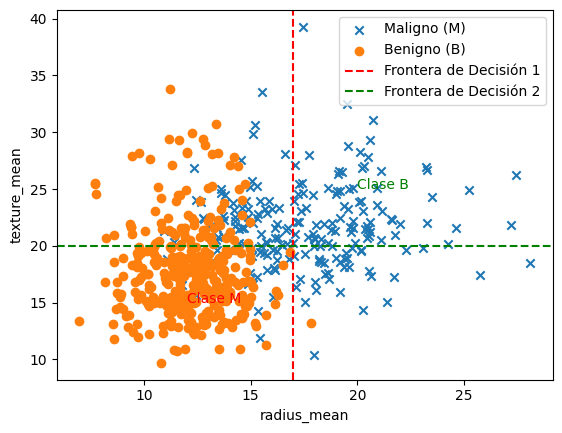

In [ ]:
import requests
import csv
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/prashant-kikani/breast-cancer-detection/master/breast-cancer-data.csv"
response = requests.get(url)
data = list(csv.reader(response.text.strip().splitlines()))

headers = data[0]
data = data[1:]

radius_mean_idx = headers.index('radius_mean')
texture_mean_idx = headers.index('texture_mean')
diagnosis_idx = headers.index('diagnosis')

clase_M = []
clase_B = []

for row in data:
    if row[diagnosis_idx] == 'M':
        clase_M.append((float(row[radius_mean_idx]), float(row[texture_mean_idx])))
    elif row[diagnosis_idx] == 'B':
        clase_B.append((float(row[radius_mean_idx]), float(row[texture_mean_idx])))

M_radius_mean, M_texture_mean = zip(*clase_M)
B_radius_mean, B_texture_mean = zip(*clase_B)

plt.scatter(M_radius_mean, M_texture_mean, label='Maligno (M)', marker='x')
plt.scatter(B_radius_mean, B_texture_mean, label='Benigno (B)', marker='o')

plt.axvline(x=17, color='r', linestyle='--', label='Frontera de Decisión 1')
plt.axhline(y=20, color='g', linestyle='--', label='Frontera de Decisión 2')

plt.text(12, 15, 'Clase M', color='r')
plt.text(20, 25, 'Clase B', color='g')

plt.xlabel('radius_mean')
plt.ylabel('texture_mean')
plt.legend()
plt.show()


##**D)Corroborar los resultados con Sklearn (2 puntos)**

Se cargaron el conjunto de datos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/prashant-kikani/breast-cancer-detection/master/breast-cancer-data.csv"
data = pd.read_csv(url)

Se seleccionaron las caracteristicas, lo que son **radius_mean** y **texture_mean**, se destaco una variable objetivo que es **diagnosis**, se dividieron los puntos por clase, así mismo se creo el gráfico de dispersión, se dibujaron las líneas de frontera de decisión y finalmente se etiquetaron las regiones resultantes

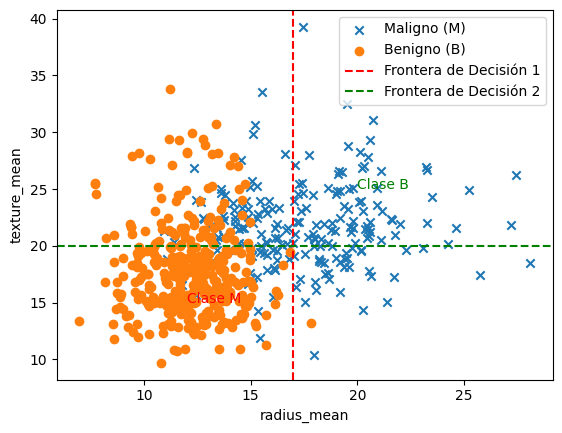

In [ ]:
X = data[['radius_mean', 'texture_mean']]
y = data['diagnosis']

clase_M = data[data['diagnosis'] == 'M']
clase_B = data[data['diagnosis'] == 'B']

plt.scatter(clase_M['radius_mean'], clase_M['texture_mean'], label='Maligno (M)', marker='x')
plt.scatter(clase_B['radius_mean'], clase_B['texture_mean'], label='Benigno (B)', marker='o')

plt.axvline(x=17, color='r', linestyle='--', label='Frontera de Decisión 1')
plt.axhline(y=20, color='g', linestyle='--', label='Frontera de Decisión 2')

plt.text(12, 15, 'Clase M', color='r')
plt.text(20, 25, 'Clase B', color='g')

plt.xlabel('radius_mean')
plt.ylabel('texture_mean')
plt.legend()
plt.show()

In [ ]:
print(data.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

##Parte 2
(25 puntos)

##**Utilizando el dataset de Grades, construir un modelo de árbol de decisión con sklearn que prediga la nota final(G3) de un estudiante. Utilizar sólo las variables numéricas(seleccionar las que considere más importantes). No utilizar las columnas G1 y G2. Utilizar validación cruzada de 5. Probar con al menos 3 alturas diferentes.(Expresar resultados en términos de promedios y desviación estándar).**

https://raw.githubusercontent.com/camilousa/datasets/master/school_grades_dataset.csv


Se cargo el dataset, se seleccionaron las variables numéricas importantes.

In [ ]:
url = "https://raw.githubusercontent.com/camilousa/datasets/master/school_grades_dataset.csv"
data = pd.read_csv(url)

numeric_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Se seleccionó la variable objetivo que en este caso es (G3), se definieron los árboles, se realizo la validación cruzada y el caluló de promedios y desviación estandar de las puntuaciones, se creo el modelo de árbol de decisión con la profundidad especifica, se realizó la validación cruzada con 5 splits, y por último se calculo el promedio y desviación estándar de las puntuaciones.

In [ ]:
target = 'G3'

X = data[numeric_features]
y = data[target]

max_depths = [3, 12, 21]

for depth in max_depths:

    model = DecisionTreeRegressor(max_depth=depth)

    scores = cross_val_score(model, X, y, cv=5)

    mean_score = scores.mean()
    std_score = scores.std()

    print(f"Altura del árbol: {depth}")
    print(f"Promedio de puntuaciones: {mean_score:.4f}")
    print(f"Desviación estándar de puntuaciones: {std_score:.4f}")
    print(" " * 30)


Altura del árbol: 3
Promedio de puntuaciones: 0.0040
Desviación estándar de puntuaciones: 0.1253
                              
Altura del árbol: 12
Promedio de puntuaciones: -1.0265
Desviación estándar de puntuaciones: 0.7784
                              
Altura del árbol: 21
Promedio de puntuaciones: -1.0921
Desviación estándar de puntuaciones: 0.7941
                              
